In [1]:
%matplotlib inline
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import imageio

import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.nn import init
from torch.optim import lr_scheduler
import torch.utils.data
#import torchvision.transforms as transforms


In [2]:
#Utils
def display3DObject(test_object):   
    print("Displaying the object")
    fig = plt.figure()
    ax = fig.gca(projection='3d')
    ax.voxels(test_object, edgecolor='k')
    plt.show()
    
def addNoise(shape, noise=0.1):
    #print(shape)
    return Variable(torch.zeros(shape).normal_(0, noise).cuda())

Displaying the object


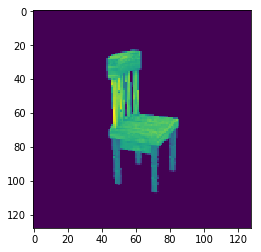

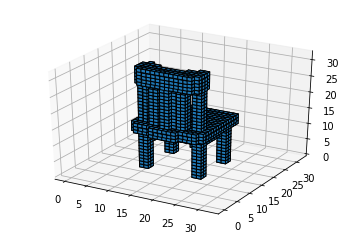

In [39]:
batch_size = 5
display_id = 56

images = np.load('padded_gray_chair_imgs.npy')
images[:] = (images[:] - np.mean(images[:])) / np.std(images[:])
voxels = np.load('chair_voxels.npy')
train_data = [voxels, images]
for _ in range(len(train_data)):
    train_data[_] = torch.from_numpy(train_data[_]).type(torch.FloatTensor)
    train_data[_] = train_data[_].cuda()
train_data = [(train_data[0][i], train_data[1][i]) for i in range(len(train_data[0]))] 
train_loader = torch.utils.data.DataLoader(
    train_data, batch_size=batch_size, shuffle=True, drop_last=True)
plt.imshow(images[display_id])
display3DObject(voxels[display_id])

Displaying the object


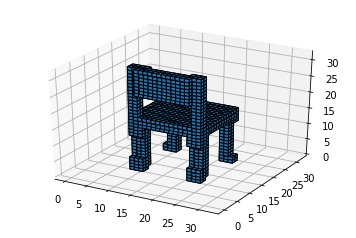

In [46]:
display3DObject(voxels[877])

In [34]:
class VAE(nn.Module):
    def __init__(self, input_nc=1, z_size=200, ndf=25, cube_size=32):
        super(VAE, self).__init__()
        self.encoderLayer1 = torch.nn.Sequential(
            torch.nn.Conv2d(input_nc, ndf, kernel_size=4, stride=2, padding=1),
            torch.nn.BatchNorm2d(ndf),
            torch.nn.ReLU()
        )
        
        self.encoderLayer2 = torch.nn.Sequential(
            torch.nn.Conv2d(ndf, ndf*2, kernel_size=4, stride=2, padding=1),
            torch.nn.BatchNorm2d(ndf*2),
            torch.nn.ReLU()
        )
        
        self.encoderLayer3 = torch.nn.Sequential(
            torch.nn.Conv2d(ndf*2, ndf*4, kernel_size=4, stride=2, padding=1),
            torch.nn.BatchNorm2d(ndf*4),
            torch.nn.ReLU()
        )
        
        self.encoderLayer4 = torch.nn.Sequential(
            torch.nn.Conv2d(ndf*4, ndf*8, kernel_size=4, stride=2, padding=1),
            torch.nn.BatchNorm2d(ndf*8),
            torch.nn.ReLU()
        )
        
        self.encoderLayer5 = torch.nn.Sequential(
            torch.nn.Conv2d(ndf*8, ndf*8, kernel_size=4, stride=4, padding=1),
            torch.nn.BatchNorm2d(ndf*8),
            torch.nn.ReLU()
        )
        
        self.encoderLayer6 = torch.nn.Sequential(
            torch.nn.Conv2d(ndf*8, ndf*8, kernel_size=4, stride=2, padding=1),
            torch.nn.Tanh()
        )
        
        self.z_size = z_size
        self.cube_size = cube_size
        
        self.fc1 = nn.Linear(ndf*8, self.z_size)
        self.fc2 = nn.Linear(ndf*8, self.z_size)
        
        self.decoderLayer1 = torch.nn.Sequential(
            torch.nn.ConvTranspose3d(self.z_size, self.cube_size*4, kernel_size=4, stride=2, padding=(0,0,0)),
            torch.nn.BatchNorm3d(self.cube_size*4),
            torch.nn.ReLU()
        )
        
        self.decoderLayer2 = torch.nn.Sequential(
            torch.nn.ConvTranspose3d(self.cube_size*4, self.cube_size*2, kernel_size=4, stride=2, padding=(1, 1, 1)),
            torch.nn.BatchNorm3d(self.cube_size*2),
            torch.nn.ReLU()
        )
        self.decoderLayer3 = torch.nn.Sequential(
            torch.nn.ConvTranspose3d(self.cube_size*2, self.cube_size*1, kernel_size=4, stride=2, padding=(1, 1, 1)),
            torch.nn.BatchNorm3d(self.cube_size*1),
            torch.nn.ReLU()
        )

        self.decoderLayer4 = torch.nn.Sequential(
            torch.nn.ConvTranspose3d(self.cube_size, 1, kernel_size=4, stride=2,  padding=(1, 1, 1)),
            torch.nn.Sigmoid()
        )
        
    def encoder(self, x): 
        out = self.encoderLayer1(x)
        out = self.encoderLayer2(out)
        out = self.encoderLayer3(out)
        out = self.encoderLayer4(out)
        out = self.encoderLayer5(out)
        out = self.encoderLayer6(out).view(-1, self.z_size)
        return self.fc1(out), self.fc2(out)
    
    #source: https://github.com/bhpfelix/Variational-Autoencoder-PyTorch/blob/master/src/vanila_vae.py
    def reparametrize(self, mu, logvar):
        std = logvar.mul(0.5).exp_()
        eps = torch.cuda.FloatTensor(std.size()).normal_()
        eps = Variable(eps)
        return eps.mul(std).add_(mu)
    
    def decoder(self, x):
        out = self.decoderLayer1(x)
        out = self.decoderLayer2(out)
        out = self.decoderLayer3(out)
        out = self.decoderLayer4(out)
        return out
    
    def forward(self, x):
        mu, sigma = self.encoder(x)
        latent = self.reparametrize(mu,sigma)
        latent = latent.view(-1,self.z_size,1,1,1)#latent.unsqueeze(2).unsqueeze(2).unsqueeze(2)
        print(latent.shape)
        object_3D = self.decoder(latent)
        return object_3D
        

In [35]:
vae = VAE().cuda()

In [38]:
lr_vae = 0.0025
lr_d = 0.001
adam_beta_vae = (0.5, 0.5)
adam_beta_d = (0.5, 0.5)
vae_solver = optim.Adam(vae.parameters(), lr=lr_vae, betas = adam_beta_vae)

In [ ]:
#Training the system
num_epochs = 20

loss = nn.BCELoss()
for epoch in range(num_epochs):
    for batch_idx, (data3d, data2d) in enumerate(train_loader):
        var_3D_data = Variable(data3d).cuda().float()
        

In [37]:
#Testing the general Structure of the VAE
test_image = Variable(torch.FloatTensor(images[6])).view(1,1,128,128).cuda()
print(test_image.shape)
vae(test_image)

torch.Size([1, 1, 128, 128])
torch.Size([1, 200, 1, 1, 1])


Variable containing:
(0 ,0 ,0 ,.,.) = 
  0.5063  0.5072  0.5068  ...   0.5042  0.5057  0.5045
  0.5027  0.5060  0.5071  ...   0.5027  0.5017  0.5051
  0.5061  0.5112  0.5044  ...   0.5112  0.4976  0.5081
           ...             ⋱             ...          
  0.5029  0.5050  0.5034  ...   0.5084  0.5032  0.5008
  0.5053  0.5069  0.5070  ...   0.5073  0.5064  0.5080
  0.5037  0.5054  0.5042  ...   0.5026  0.5011  0.5050

(0 ,0 ,1 ,.,.) = 
  0.5056  0.5102  0.5084  ...   0.5062  0.5041  0.5067
  0.5041  0.5084  0.5107  ...   0.5157  0.5057  0.5134
  0.5056  0.5113  0.5024  ...   0.5107  0.5037  0.5009
           ...             ⋱             ...          
  0.5035  0.5154  0.5039  ...   0.5199  0.5026  0.5041
  0.5057  0.5229  0.4920  ...   0.5011  0.5082  0.4975
  0.5047  0.5097  0.4986  ...   0.5123  0.4999  0.5028

(0 ,0 ,2 ,.,.) = 
  0.5070  0.5110  0.5103  ...   0.5105  0.5039  0.5053
  0.5036  0.5109  0.4979  ...   0.4993  0.4920  0.4982
  0.5087  0.5011  0.4990  ...   0.5008  0.5